# Hypotheses Testing Project with data from the Northwind database


### Importing libraries and connecting SQL database

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flatiron_stats as fs
import numpy as np
from IPython.display import Image
import scipy.stats
import math

from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()


#connection to SQL database
conn = sqlite3.connect('Northwind_small.sqlite')
cur  = conn.cursor()

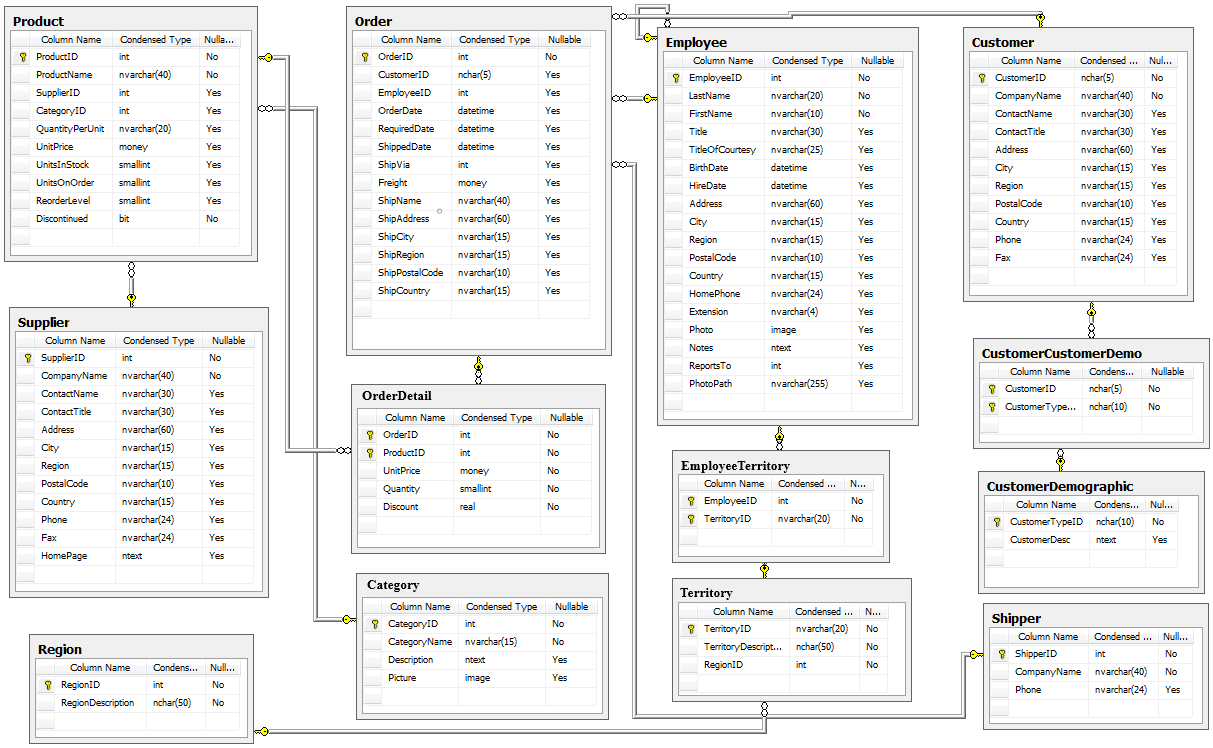

In [2]:
Image("Northwind_ERD_updated.png")

## Q1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Initial data exploration

In [3]:
#SQL query
order_detail = cur.execute('''SELECT * FROM OrderDetail;''').fetchall()

#Creating Pandas DF with fetched data and renaming columns
order_detail_df = pd.DataFrame(order_detail)
order_detail_df.columns = ['orderID/productID','orderID','productID','unit_price','quantity','discount']

#Crating a new column which calculates the total price of each product(quantity x price)
order_detail_df['total_price'] = order_detail_df.apply(lambda row: row.unit_price * row.quantity, axis = 1) 
order_detail_df['total_price_ad'] = order_detail_df.apply(lambda row: row.total_price-(row.total_price * row.discount), axis = 1) 


order_detail_df.head(10)

,orderID/productID,orderID,productID,unit_price,quantity,discount,total_price,total_price_ad
0,10248/11,10248,11,14.0,12,0.00,168.0,168.00
1,10248/42,10248,42,9.8,10,0.00,98.0,98.00
2,10248/72,10248,72,34.8,5,0.00,174.0,174.00
3,10249/14,10249,14,18.6,9,0.00,167.4,167.40
4,10249/51,10249,51,42.4,40,0.00,1696.0,1696.00
5,10250/41,10250,41,7.7,10,0.00,77.0,77.00
6,10250/51,10250,51,42.4,35,0.15,1484.0,1261.40
7,10250/65,10250,65,16.8,15,0.15,252.0,214.20
8,10251/22,10251,22,16.8,6,0.05,100.8,95.76
9,10251/57,10251,57,15.6,15,0.05,234.0,222.30


In [4]:
order_detail_df.discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: discount, dtype: int64

We can see that the main discount categories are: 
* 5%
* 10%
* 15%
* 20%
* 25%

Smaller discount rates exist in the database, but are very rare (8 rows out of 2155)
I will only consider the above mentioned discount rates for answering the question to avoid creating unnecessary 
discount categories.

In [5]:
# total sales for different discount rates
sales_per_discount_1 = order_detail_df.groupby('discount').sum()
sales_per_discount_2 = sales_per_discount_1.sort_values(by='quantity',ascending=False, axis=0).head(6)
sales_per_discount_2 = sales_per_discount_2.drop('orderID', axis=1)
sales_per_discount_2 = sales_per_discount_2.drop('productID', axis=1)
sales_per_discount_2 = sales_per_discount_2.drop('unit_price', axis=1)
sales_per_discount_2

,quantity,total_price,total_price_ad
discount,,,
0.00,28599,750698.61,750698.6100
0.05,5182,155386.71,147617.3745
0.15,4456,102948.44,87506.1740
0.10,4366,101665.71,91499.1390
0.20,4351,111476.38,89181.1040
0.25,4349,131918.09,98938.5675


This table shows us the main discount categories, number of total products sold and the total price.
28599 products were sold without any discount.
Between 4349 and 5182 products were sold per each discount category - total of 22704.

### Preparing variables for hypotheses testing

In [6]:
#Removing outliers (quantities higher than 100 - only 23 rows in total, it does not effect the p-value)
discount_0 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.0 and quantity <100;''').fetchall()
discount_5 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.05 and quantity <100;''').fetchall()
discount_10 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.1 and quantity <100;''').fetchall()
discount_15 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.15 and quantity <100;''').fetchall()
discount_20 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.2 and quantity <100;''').fetchall()
discount_25 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.25 and quantity <100;''').fetchall()

#This query resulted in a list of tuples. This function transforms there variables into lists.
def tuple_to_list(item):
    results = []
    for t in item: 
        for x in t: 
            results.append(x) 
    return results

disc_0 = tuple_to_list(discount_0)
disc_5 = tuple_to_list(discount_5)
disc_10 = tuple_to_list(discount_10)
disc_15 = tuple_to_list(discount_15)
disc_20 = tuple_to_list(discount_20)
disc_25 = tuple_to_list(discount_25)

#These two variable are arrays for products sold with some discount(includes all discount categories) and without
#any discount
overall = np.array(disc_0 + disc_5 + disc_10 + disc_15 + disc_20 + disc_25)
no_discount = np.array(disc_0)
some_discount = np.array(disc_5 + disc_10 + disc_15 + disc_20 + disc_25)



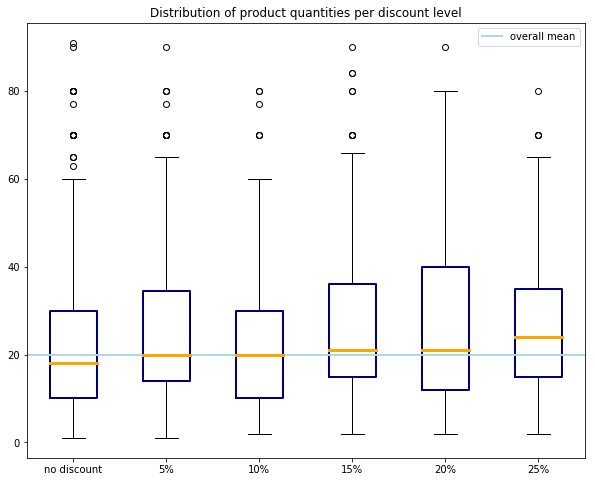

In [7]:
fig = plt.figure(1,figsize=(10,8))
ax = fig.add_subplot(111)
bp = ax.boxplot([disc_0,disc_5,disc_10,disc_15,disc_20,disc_25],labels=['no discount','5%','10%','15%','20%','25%'])
plt.title('Distribution of product quantities per discount level');

for box in bp['boxes']:
    box.set(color='navy', linewidth=2)
    
for median in bp['medians']:
    median.set(color='orange', linewidth=3)
plt.axhline(y=20, linewidth=2, color = 'lightblue',label='overall mean')
plt.legend()


The **median quantity** of products order increases slighltly with a discount applied.
* No discount =  **18**
* Overall = **20**
* 5%,10% = **20**
* 15%,20% = **21**
* 25% = **24**


 ### Q1: Hypothesis (1)

**Ho: Discount does not increase the number of products sold.**

**H1: Discount does have a statistically significant effect on the increase of the number of products sold.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test

Let's treat no_discount as the control group and some_discount as the experimental group

### Welch's T-Test

In [8]:
fs.p_value_welch_ttest(no_discount, some_discount, two_sided=False)

1.1288081580573817e-11

**Result: 1.1288081580573817e-11**

This very small p-value indicates that there is a statistically significant effect of discount on the quantity of products sold. 

### Effect size

In [9]:
#This function calculates Cohen's D - the difference between two means, measured in standard deviations.

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

Cohen_d(some_discount,no_discount) #first experimental group, second is control group

0.3116249688964361

**Result: 0.31 - small positive effect.**
A positive effect size indicates that the effect increases the mean.
This means that the discount has a small positive effect on the number of products ordered.

**We can reject Ho** - Discounts in gereneal have a statistically significant small positive effect

### Q1: Hypothesis (2)

**Ho: There is no statistically significant difference between various discount levels and their effect on increasing quantity of product sold.**

**H1: There are discount levels that have statistically significant effect on increasing the quantity of products sold.**
   
**$\alpha$: 0.05**


In [10]:
scipy.stats.f_oneway(disc_5, disc_10, disc_15, disc_20, disc_25)

F_onewayResult(statistic=1.1843556566943465, pvalue=0.3161974897360752)

**Result: 0.316**
This high p-value indicates that there is no statistically significant difference between those groups.

**We can reject H1**


### Q1: Hypothesis (3)

**Ho: Compared to no discount, there is no statistically significant difference between various discount levels and their effect on increasing quantity of product sold.**

**H1: There are discount levels that have statistically significant effect on increasing the quantity of products sold, compared no no discount at all.**

**$\alpha$: 0.05**

I will perform a 1-sided test

I will first perform Welch's T-test across all discount levels in comparison with no discount.

In [11]:
discounts = [disc_5, disc_10, disc_15, disc_20, disc_25]

for item in discounts:
    item = np.array(item)
    results = fs.p_value_welch_ttest(no_discount, item, two_sided=False)
    print(results)

0.00011015097977618016
0.03140764110408012
4.2947873018173155e-05
0.00010702250945293645
5.217000575719055e-05


All of these p-values are very small, which suggests there is a significant difference between their means and the mean of the no_discount variable.
Discount levels **15% and 25% have much lower p-value** than other groups.
**10% discount has the highest p-value of 0.03**

Which discount level has the biggest effect size?

In [12]:
for item in discounts:
    item = np.array(item)
    results = Cohen_d(item,no_discount)
    print(results)

0.35196133789659617
0.16235556161327822
0.40701280436876425
0.35499791035177525
0.3653568580130326


These results indicate that the discount rates with the biggest effect size are:
* 15% - effect size of 0.4
* 25%, 20%, 5% - effect size 0.35-0.36

10% has the lowest effect size - 0.1

#### What does a Cohen's D of 0.4  mean?

* with a Cohen's d of 0.4, 66 % of the treatment group will be above the mean of the control group
* there is a 61 % chance that a variable picked at random from the treatment group(15% discount) will have a higher score than a variable picked at random from the control group (no discount) = probability of superiority.

#### Power Analysis

In [13]:
###power analysis for disc_0 and disc_15
print('Power of the test for 15% discount:')
print(power_analysis.solve_power(alpha=0.05, effect_size=0.407, nobs1=len(disc_15)))
print('Power of the test for 25% discount:')
print(power_analysis.solve_power(alpha=0.05, effect_size=0.365, nobs1=len(disc_25)))
print('Power of the test for 20% discount:')
print(power_analysis.solve_power(alpha=0.05, effect_size=0.354, nobs1=len(disc_20)))
print('Power of the test for 5% discount:')
print(power_analysis.solve_power(alpha=0.05, effect_size=0.351, nobs1=len(disc_5)))
print('Power of the test for 10% discount:')
print(power_analysis.solve_power(alpha=0.05, effect_size=0.162, nobs1=len(disc_10)))

Power of the test for 15% discount:
0.9465004142122686
Power of the test for 25% discount:
0.8851980070303229
Power of the test for 20% discount:
0.8842945582023544
Power of the test for 5% discount:
0.9161245618914382
Power of the test for 10% discount:
0.3192297024964834


 **Result (15% discount): 0.94** This means that the probability of rejecting the Ho (if the Ho is false) is 94% 
 
 **Result (10% discount): 0.31** This means that the probability of rejecting the Ho (if the Ho is false) is 31%. This value is too high - the risk this error is high 

### Summary of findings from Q1:

* Discounts have statistically significant effect on increasing the quantity of sold products
* When compared to each other, there is no significant difference between the discount levels themselves
* However, compared to no discount at all, the most effective discount levels is 15%
* 25%, 20% and 5% have a similar effect 
* The least effective discount level seems to be 10%, but further investigation is needed to confim this

# Q2: What is the effect of discounts on revenue from sold products after discount?

### Q2: Hypothesis (1)

**Ho: Discounts do not increase the overall revenue.**

**H1: Discounts do have a statistically significant effect on the increase of revenue.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test

In [14]:
#preparing variables for testing

order_detail_df.head()

rev_0 = order_detail_df.loc[(order_detail_df['discount']==0.0) & (order_detail_df['total_price_ad']<6000)]
rev_5 = order_detail_df.loc[(order_detail_df['discount']==0.05) & (order_detail_df['total_price_ad']<6000)]
rev_10 = order_detail_df.loc[(order_detail_df['discount']==0.1) & (order_detail_df['total_price_ad']<6000)]
rev_15 = order_detail_df.loc[(order_detail_df['discount']==0.15) & (order_detail_df['total_price_ad']<6000)]
rev_20 = order_detail_df.loc[(order_detail_df['discount']==0.20) & (order_detail_df['total_price_ad']<6000)]
rev_25 = order_detail_df.loc[(order_detail_df['discount']==0.25) & (order_detail_df['total_price_ad']<6000)]

revenue_0 = list(rev_0.total_price_ad)
revenue_5 = list(rev_5.total_price_ad)
revenue_10 = list(rev_10.total_price_ad)
revenue_15 = list(rev_15.total_price_ad)
revenue_20 = list(rev_20.total_price_ad)
revenue_25 = list(rev_25.total_price_ad)

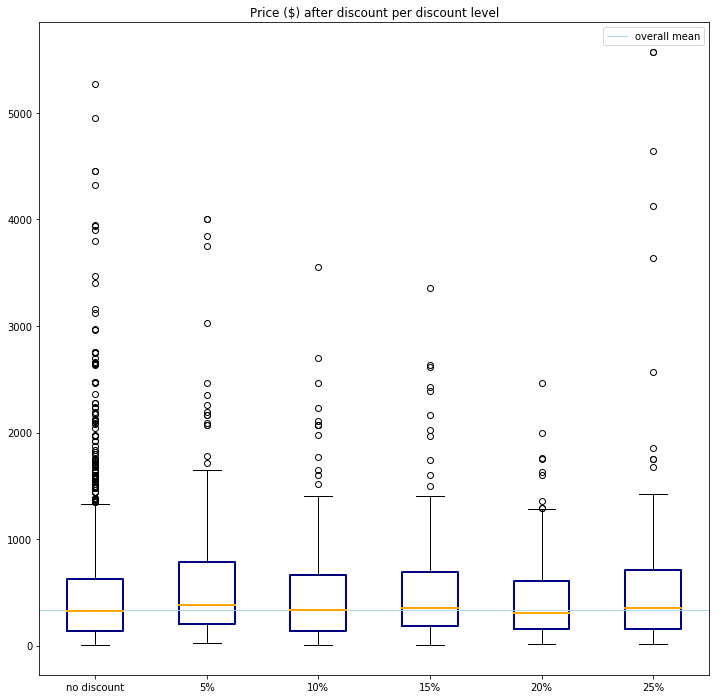

In [15]:
fig = plt.figure(1,figsize=(12,12))
ax = fig.add_subplot(111)
bp = ax.boxplot([revenue_0, revenue_5, revenue_10, revenue_15, revenue_20, revenue_25],labels=['no discount','5%','10%','15%','20%','25%'])

plt.title('Price ($) after discount per discount level');

for box in bp['boxes']:
    box.set(color='navy', linewidth=2)
    
for median in bp['medians']:
    median.set(color='orange', linewidth=2)
plt.axhline(y=336, linewidth=1, color = 'lightblue',label='overall mean')
plt.legend();


The **median price** of products ordered does **not** necessarily increase  with a discount applied.
* No discount =  **321**
* Overall = **336**
* 5% = **383**
* 10% = **334**
* 15% = **357**
* 20% = **304**
* 25% = **351**

### Welch's T-test

In [16]:
#grouping discounts together into single varible
total_rev_any_discount = revenue_5 + revenue_10 + revenue_15 + revenue_20 +revenue_25
revenue_no_disc = np.array(revenue_0)
revenue_any_disc = np.array(total_rev_any_discount)

#Welch's T-test
fs.p_value_welch_ttest(revenue_no_disc, revenue_any_disc, two_sided=False)

0.03918142747864817

**Result: 0.03**
This p-value is lower than our alpha of 0.05. We can this reject the Ho.

Note:
If we do not consider the after discount price:
**Result: 5.248554325509858e-05**
This a much smaller p-value, which suggests bigger difference between revenues with discount and without

In [17]:
Cohen_d(revenue_any_disc,revenue_no_disc) #first experimental group, second is control group

0.0799311741351135

**Result: 0.07**
This suggests an extremely small positive effect

### Q2: Hypothesis (2)

**Ho: There is no difference between various discount levels and their impact on incresing revenue.**

**H1: Discounts have a varied effect on increasing revenue.**
   
**$\alpha$: 0.05**


In [18]:
scipy.stats.f_oneway(revenue_5, revenue_10, revenue_15, revenue_20, revenue_25)

F_onewayResult(statistic=2.1650222909269985, pvalue=0.07118388822483022)

**Result: 0.07** 

This is higher than alpha, we can reject H1. 
This p-value is still small however. Let's find our more about this effect by testing another hypothesis.

### Q2: Hypothesis (3)

**Ho: There is no difference between various discount levels and their impact on incresing revenue compared to no discount.**

**H1: Discounts have a varied effect on increasing revenue compared to no discount.**
   
**$\alpha$: 0.05**

In [19]:
list_rev_any_disc = [revenue_5, revenue_10, revenue_15, revenue_20, revenue_25]

for item in list_rev_any_disc:
    item = np.array(item)
    results = fs.p_value_welch_ttest(revenue_no_disc, item, two_sided=False)
    print(results)

0.007483442074049718
0.3571112450630549
0.17679823296488628
0.0750348493325993
0.10124275284056972


**Only 5% discount seems to have a statistically significant effect.** 20% discount's p-value is 0.07 - just over our alpha level.

We can reject the Ho. There is a single discount level with low enough p-value. 
* This suggests that only customers with 5% discount spend more in their products compared to orders without any discount
* The amount that customers spend with other discount is not significanlty different than without discount

Let's investigate effect size.

In [20]:
for item in list_rev_any_disc:
    item = np.array(item)
    results = Cohen_d(item,revenue_no_disc)
    print(results)

0.22677762098149612
0.0285701481989444
0.07548674272370728
-0.09380788417089762
0.1456962842770064


The largest effect size is in 5% discount level - Cohen's D of 0.2 - small positive effect.

Discount level 20% seems to have a small negative effect.

### Summary of findings from Q2:

* If we consider the actual price customers pay after applying discount, overall revenue does not necessarily increase
* Customers order more products if they have access to a discount, but the overall revenue for the business does not increase
* Only 5% discount causes increased revenue on a statistically significant level
* More investigation needed! Discounts might have other positive benefits, such as attracting new customers, customer retention and satisfaction

In [21]:
#SQL query
order = cur.execute('''SELECT * FROM [Order];''').fetchall()

#Creating Pandas DF with fetched data and renaming columns
order_df = pd.DataFrame(order)
order_df.columns = ['orderID','customerID','empl_ID','order_d','req_date','ship_date','ship_via','freight','s_name','s_address','s_city','s_region','s_code','s_country']

In [22]:
order_df.head()

,orderID,customerID,empl_ID,order_d,req_date,ship_date,ship_via,freight,s_name,s_address,s_city,s_region,s_code,s_country
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [23]:
order_detail_df.head()

,orderID/productID,orderID,productID,unit_price,quantity,discount,total_price,total_price_ad
0,10248/11,10248,11,14.0,12,0.0,168.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0,1696.0


## Q3: Does the company receive larger orders in the two months preceding Christmas?

### Q3: Hypothesis (1)

**Ho: The company does not receive significantly larger orders into two months preceding Christmas compared to other two-month section of the year**

**H1: Discount does have a statistically significant effect on the increase of the number of products sold.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test


In [24]:
#preparing varibles
order_sizes = order_detail_df.groupby('orderID').sum()

#setting new index
order_index = order_df.set_index('orderID')

#joining tables
joined_df = order_index.join(order_sizes)

#dropping columns
orders = joined_df.drop(['customerID','empl_ID','ship_via','freight','s_name','s_address','s_code','productID','unit_price','discount','total_price'],axis=1)

#changing columns into datetime objects
orders['order_d'] = pd.to_datetime(orders['order_d'])

#slicing df into four quarters of the year
first_q = orders[orders.order_d.dt.month.isin([1,2,3])]
second_q = orders[orders.order_d.dt.month.isin([4,5,6])]
third_q = orders[orders.order_d.dt.month.isin([7,8,9])]
fourth_q = orders[orders.order_d.dt.month.isin([10,11,12])]

#getting variables
first_qq = np.array(first_q.quantity)
second_qq = np.array(second_q.quantity)
third_qq = np.array(third_q.quantity)
fourth_qq = np.array(fourth_q.quantity)

all_quarters = [first_qq,second_qq,third_qq,fourth_qq]

In [25]:
#exploring 
print('The median quantity of each product ordered:')
print('Overall: '+str(orders.quantity.median()))
print('1st quarter: '+str(np.median(first_qq)))
print('2nd quarter: '+str(np.median(second_qq)))
print('3rd quarter: '+str(np.median(third_qq)))
print('4th quarter: '+str(np.median(fourth_qq)))

The median quantity of each product ordered:
Overall: 50.0
1st quarter: 50.0
2nd quarter: 48.0
3rd quarter: 46.0
4th quarter: 53.5


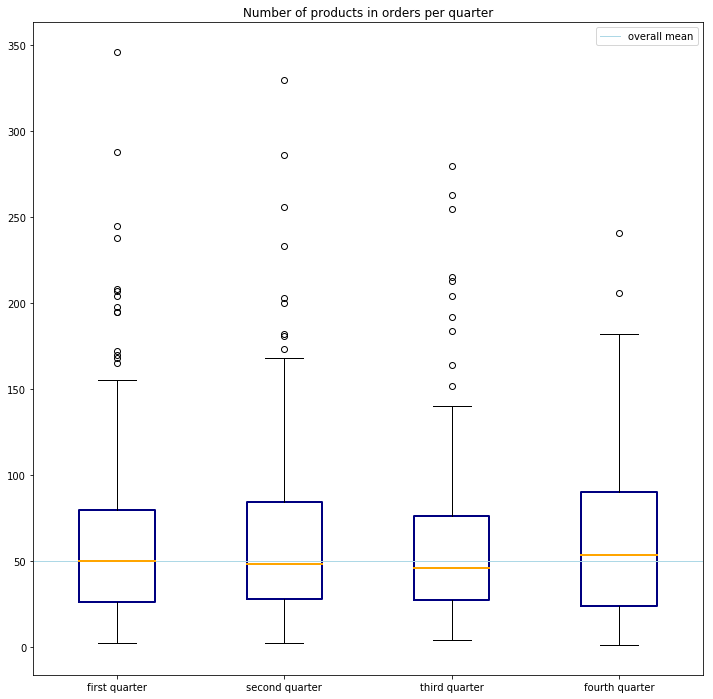

In [26]:
fig = plt.figure(1,figsize=(12,12))
ax = fig.add_subplot(111)
bp = ax.boxplot(all_quarters,labels=['first quarter','second quarter','third quarter','fourth quarter'])

plt.title('Number of products in orders per quarter');

for box in bp['boxes']:
    box.set(color='navy', linewidth=2)
    
for median in bp['medians']:
    median.set(color='orange', linewidth=2)
plt.axhline(y=50, linewidth=1, color = 'lightblue',label='overall mean')
plt.legend();

#### F-one-way test

In [27]:
scipy.stats.f_oneway(first_qq,second_qq,third_qq,fourth_qq)

F_onewayResult(statistic=0.3229822291389121, pvalue=0.8087609911036548)

**Result: 0.8** This high p-value means we can comfortably reject H1. Order sizes are not significantly different across various quarters.

#### Welch's T-test - testing last quarter against other quarters

In [28]:
for item in all_quarters[0:3]:
    item = np.array(item)
    results = fs.p_value_welch_ttest(fourth_qq, item, two_sided=False)
    print(results)

0.3339529664847365
0.40059379803391826
0.16061960307027368


### Q2: Hypothesis (2) - Is there a significant difference between continets and their order size before Christmas?

In [29]:
fourth_q.s_region.value_counts()
#I will remove Eastern Europe, Central Ameria and Scandinavia from the selection due to small number of samples

Western Europe     68
North America      37
South America      30
British Isles      25
Northern Europe    16
Southern Europe    13
Scandinavia         6
Central America     5
Eastern Europe      2
Name: s_region, dtype: int64

In [30]:
#preparing variables

all_regions = ['British Isles','Western Europe','North America', 
               'Southern Europe','Northern Europe','South America']

BI = np.array(fourth_q.loc[fourth_q.s_region == all_regions[0],'quantity'])
WE = np.array(fourth_q.loc[fourth_q.s_region == all_regions[1],'quantity'])
NA = np.array(fourth_q.loc[fourth_q.s_region == all_regions[2],'quantity'])
SE = np.array(fourth_q.loc[fourth_q.s_region == all_regions[3],'quantity'])
NE = np.array(fourth_q.loc[fourth_q.s_region == all_regions[4],'quantity'])
SA = np.array(fourth_q.loc[fourth_q.s_region == all_regions[5],'quantity'])
ALL = np.array(fourth_q['quantity'])

all_countries= [BI,WE,NA,SE,NE,SA]



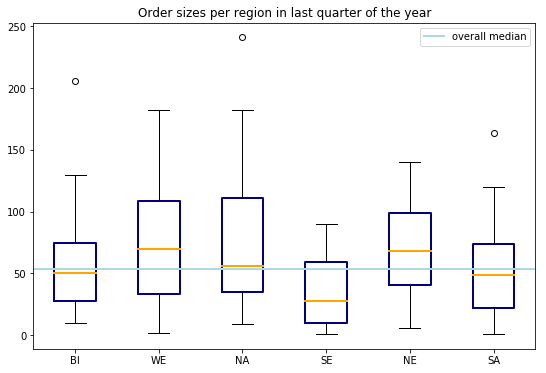

In [31]:
fig = plt.figure(1,figsize=(9,6))
ax = fig.add_subplot(111)
bp = ax.boxplot(all_countries,labels=['BI','WE','NA','SE','NE','SA'])
plt.title('Order sizes per region in last quarter of the year');

for box in bp['boxes']:
    box.set(color='navy', linewidth=2)
    
for median in bp['medians']:
    median.set(color='orange', linewidth=2)
plt.axhline(y=53.5, linewidth=2, color = 'lightblue',label='overall median')
plt.legend();

#### F-one-way test

In [32]:
scipy.stats.f_oneway(BI,WE,NA,SE,NE,SA)

F_onewayResult(statistic=2.905382526528915, pvalue=0.015031654106101354)

**Result: 0.01** This low p-value means that we can reject the Ho. Order sizes vary significantly between regions.

### Summary of findings from Q3:

* The company does not receive significantly larger orders in the three months preceding Christmas compared to other quarters of the year
* This suggest that there might be a potential for expanding the company's product ranges that might be suitable for Christmas market
* Customers from Western and Northern Europe are purchasing the largers orders in the last quarter of the year. It is important to maintain realiable shipping services to avoid delivery complications

## Q4: Does it matter which employee manages an order? Do some employees sell higher value orders?

**Ho: All employees tend to sell similarly expensive orders**

**H1: There are employees that perform significantly better at selling**

In [41]:
#preparing variables

performance_df  = joined_df.drop(['customerID','order_d','req_date','ship_date','s_city','s_region','s_country','ship_via','freight','s_name','s_address','s_code','productID'],axis=1)

In [42]:
performance_df.head()

,empl_ID,unit_price,quantity,discount,total_price,total_price_ad
orderID,,,,,,
10248,5,58.6,27,0.0,440.0,440.00
10249,6,61.0,49,0.0,1863.4,1863.40
10250,4,66.9,60,0.3,1813.0,1552.60
10251,3,49.2,41,0.1,670.8,654.06
10252,4,94.0,105,0.1,3730.0,3597.90


In [43]:
performance_df.groupby('empl_ID').sum()

,unit_price,quantity,discount,total_price,total_price_ad
empl_ID,,,,,
1,8732.44,7812,16.99,202143.71,192107.6045
2,6913.41,6055,10.55,177749.26,166537.7550
3,8748.42,7852,15.95,213051.30,202812.8430
4,11187.29,9798,25.75,250187.45,232890.8460
5,2747.43,3036,7.80,75567.75,68792.2825
6,3834.96,3527,9.15,78198.10,73913.1295
7,4717.51,4654,12.95,141295.99,124568.2350
8,6239.25,5913,14.60,133301.03,126862.2775
9,3380.20,2670,7.30,82964.00,77308.0665


In [56]:
# preparing variables
Nancy = np.array(performance_df.loc[(performance_df['empl_ID']==1),'total_price'])
Andrew = np.array(performance_df.loc[(performance_df['empl_ID']==2),'total_price'])
Janet = np.array(performance_df.loc[(performance_df['empl_ID']==3),'total_price'])
Margaret = np.array(performance_df.loc[(performance_df['empl_ID']==4),'total_price'])
Steven = np.array(performance_df.loc[(performance_df['empl_ID']==5),'total_price'])
Michael = np.array(performance_df.loc[(performance_df['empl_ID']==6),'total_price'])
Robert = np.array(performance_df.loc[(performance_df['empl_ID']==7),'total_price'])
Laura = np.array(performance_df.loc[(performance_df['empl_ID']==8),'total_price'])
Anne = np.array(performance_df.loc[(performance_df['empl_ID']==9),'total_price'])
everyone = np.array(performance_df['total_price'])

all_empl = [Nancy, Andrew, Janet, Margaret, Steven, Michael, Robert, Laura, Anne]
np.median(everyone)

1015.9

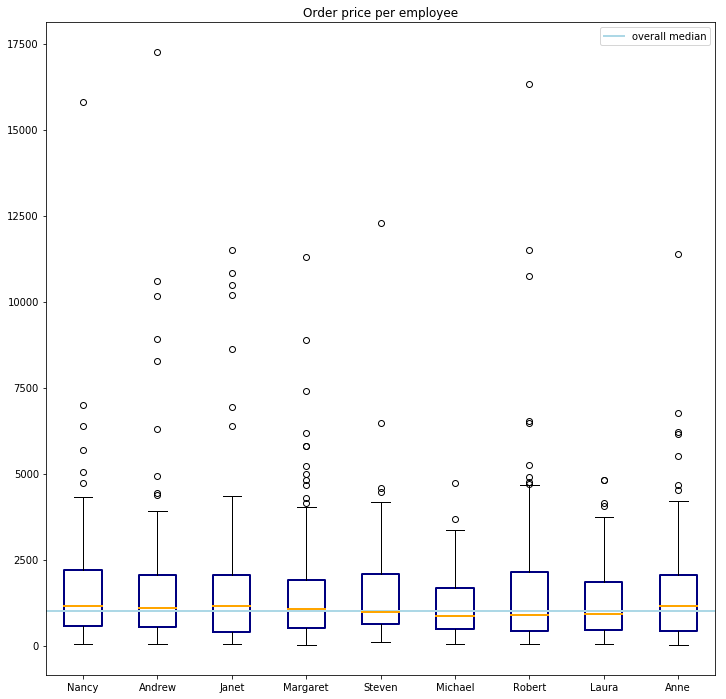

In [58]:
fig = plt.figure(1,figsize=(12,12))
ax = fig.add_subplot(111)
bp = ax.boxplot(all_empl,labels=['Nancy', 'Andrew', 'Janet', 'Margaret', 'Steven', 'Michael', 'Robert', 'Laura', 'Anne'])
plt.title('Order price per employee');

for box in bp['boxes']:
    box.set(color='navy', linewidth=2)
    
for median in bp['medians']:
    median.set(color='orange', linewidth=2)
plt.axhline(y=1016, linewidth=2, color = 'lightblue',label='overall median')
plt.legend();

In [59]:
scipy.stats.f_oneway(Nancy,Andrew,Janet,Margaret,Steven,Michael,Robert,Laura,Anne)

F_onewayResult(statistic=1.4288674243895791, pvalue=0.18038477494594063)

**Result: 0.18** This p-value is high enough for us to reject the alternative hypothesis.

In [38]:
#confidence interval
import math # delete this
import scipy.stats as stats

In [105]:
def conf_interval(sample):
    sample = sample.astype(int)
    n = len(sample)
    sample_mean = sample.mean()
    t = stats.t.ppf(q = 0.975, df=len(sample-1))  #t-critical value for 95% confidence
    sigma = sample.std()/math.sqrt(len(sample))
    margin_of_error = t * sigma #margin of error calculation
    conf = (sample_mean - margin_of_error, sample_mean + margin_of_error)
    return np.array(conf)


In [116]:
def conf_interval_samples(name_of_sample):
    sample_means = []
    intervals = []

    for sample in range(1):
        # Take a random sample of chosen size without replacement
        sub_sample = np.random.choice(a= name_of_sample, size = len(name_of_sample-10), replace=False)
    
        # Calculate confidence_interval using above function
        confidence_interval = np.array(conf_interval(sub_sample))    

        # Calculate the sample mean 
        sample_mean = sub_sample.mean()
    
        # Calculate and append sample means and conf intervals for each iteration
        sample_means.append(sample_mean)
        intervals.append(confidence_interval)
        
    return sample_means,np.array(intervals)

In [117]:
#all_empl = [Nancy, Andrew, Janet, Margaret, Steven, Michael, Robert, Laura, Anne]
Nancy_c = conf_interval_samples(all_empl[0])
Andrew_c = conf_interval_samples(all_empl[1])
Janet_c = conf_interval_samples(all_empl[2])
Margaret_c = conf_interval_samples(all_empl[3])
Steven_c = conf_interval_samples(all_empl[4])
Michael_c = conf_interval_samples(all_empl[5])
Robert_c = conf_interval_samples(all_empl[6])
Laura_c = conf_interval_samples(all_empl[7])
Anne_c = conf_interval_samples(all_empl[8])

all_conf = [Nancy_c, Andrew_c, Janet_c, Margaret_c, Steven_c, Michael_c, Robert_c, Laura_c, Anne_c]

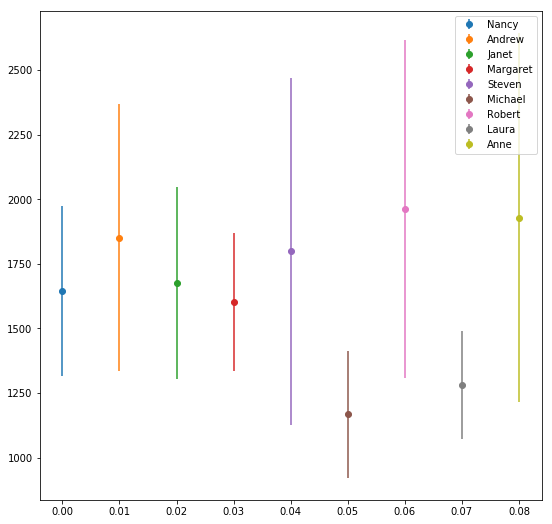

In [128]:
plt.figure(figsize=(9,9))


plt.errorbar(x=np.arange(0, 1, 1),y=all_conf[0][0],yerr=[(top-bot)/2 for top,bot in all_conf[0][1]], fmt='o',label='Nancy')
plt.errorbar(x=np.arange(0.01, 1, 1),y=all_conf[1][0],yerr=[(top-bot)/2 for top,bot in all_conf[1][1]],fmt='o',label='Andrew')
plt.errorbar(x=np.arange(0.02, 1, 1),y=all_conf[2][0],yerr=[(top-bot)/2 for top,bot in all_conf[2][1]],fmt='o',label='Janet')
plt.errorbar(x=np.arange(0.03, 1, 1),y=all_conf[3][0],yerr=[(top-bot)/2 for top,bot in all_conf[3][1]],fmt='o',label='Margaret')
plt.errorbar(x=np.arange(0.04, 1, 1),y=all_conf[4][0],yerr=[(top-bot)/2 for top,bot in all_conf[4][1]],fmt='o',label='Steven')
plt.errorbar(x=np.arange(0.05, 1, 1),y=all_conf[5][0],yerr=[(top-bot)/2 for top,bot in all_conf[5][1]],fmt='o',label='Michael')
plt.errorbar(x=np.arange(0.06, 1, 1),y=all_conf[6][0],yerr=[(top-bot)/2 for top,bot in all_conf[6][1]],fmt='o',label='Robert')
plt.errorbar(x=np.arange(0.07, 1, 1),y=all_conf[7][0],yerr=[(top-bot)/2 for top,bot in all_conf[7][1]],fmt='o',label='Laura')
plt.errorbar(x=np.arange(0.08, 1, 1),y=all_conf[8][0],yerr=[(top-bot)/2 for top,bot in all_conf[8][1]],fmt='o',label='Anne')

plt.legend()
plt.show()